In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple


class RCMDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    discount: float  # discount
    costs: jnp.array  # cost functions
    threshes: jnp.array  # constraint thresholds
    U: jnp.array  # uncertainty set
    init_dist: jnp.array  # initial distribution

    @property
    def S(self) -> int:  # state space size
        return len(self.S_set)

    @property
    def A(self) -> int:  # action space size
        return len(self.A_set)


S, A = 4, 2  # state and action space sizes
N = 1  # number of constraints
USIZE = 2  # size of uncertainty set
DISCOUNT = 0.9

assert USIZE == 2
assert N == 1

In [3]:
from typing import NamedTuple, Optional


def create_rcmdp():
    # create the RCMDP in Figure 1

    S_set = jnp.arange(S)
    A_set = jnp.arange(A)
    const = jnp.zeros(N)  # dummy

    # randomly create cost function
    costs = np.ones((N+1, S, A))

    # objective 
    costs[0, 0, 0] = 0
    costs[0, 0, 1] = 1
    costs[0, 1, :] = 1
    costs[0, 2, :] = 1
    costs[0, 3, :] = 0

    # constraint
    costs[1, 0, 0] = 1
    costs[1, 0, 1] = DISCOUNT
    costs[1, 1, :] = 1
    costs[1, 2, :] = 0
    costs[1, 3, :] = 1
    costs = jnp.array(costs)

    # create initial distribution
    init_dist = jnp.ones(S) / S
    # np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

    # create uncertainty set
    U = np.zeros((USIZE, S, A, S))
    U[0, 0, 0, 1] = 1
    U[0, 0, 1, 0] = 1
    U[0, 1, 0, 0] = 1
    U[0, 1, 1, 1] = 1
    U[0, 2, :, 2] = 1
    U[0, 3, :, 2] = 1
    U[1, 0, 0, 1] = 1
    U[1, 0, 1, 0] = 1
    U[1, 1, :, 1] = 1
    U[1, 2, :, 3] = 1
    U[1, 3, :, 3] = 1
    U = jnp.array(U)

    const = 0.6 / (1 - DISCOUNT)
    rcmdp = RCMDP(S_set, A_set, DISCOUNT, costs, const, U, init_dist)
    return rcmdp

rcmdp = create_rcmdp()

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    Args:
        policy (jnp.ndarray): (SxA) array

    Returns:
        policy_matrix (jnp.ndarray): (SxSA) array
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@partial(jax.vmap, in_axes=(None, None, 0, None), out_axes=0)
@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_Q(discount: float, policy: jnp.ndarray, cost: jnp.ndarray, P: jnp.ndarray):
    """ Do policy evaluation with cost and transition kernel
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        cost (jnp.ndarray): cost function. (SxA) array
        P (jnp.ndarray): transition kernel. (SxAxS) array

    Returns:
        Q (jnp.ndarray): (SxA) array
    """
    S, A = policy.shape

    Pi = compute_policy_matrix(policy)
    PPi = P.reshape(S*A, S) @ Pi
    Q = jnp.linalg.inv(jnp.eye(S*A) - discount * PPi) @ cost.reshape(S*A)
    return Q.reshape(S, A)


@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_visit_s(discount: float, policy: jnp.ndarray, init_dist: jnp.ndarray, P: jnp.ndarray):
    """ Compute (unnormalized) occupancy measure of a policy
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        init_dist: initial distribution
        P (jnp.ndarray): (SxAxS) array

    Returns:
        d_pi (jnp.ndarray): (S) array
    """
    Pi = compute_policy_matrix(policy)
    PiP = Pi @ P.reshape(S*A, S) 
    d_pi = init_dist @ jnp.linalg.inv(jnp.eye(S) - discount * PiP)
    return d_pi


In [5]:
from functools import partial
from tqdm import tqdm


@jax.jit
def compute_Llam(rcmdp: RCMDP, lam: float, policy: jnp.ndarray):
    """compute Lλ(pi) and ∇Lλ(pi)

    Args:
        rcmdp (RCMDP)
        lam (float): value of λ
        policy (jnp.ndarray): policy

    Returns:
        Lλ(pi), ∇Lλ(pi)
    """
    Qs = compute_policy_Q(rcmdp.discount, policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
    Js = jnp.sum((Qs * policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1)
    idx = jnp.argmax(Js, axis=-1)  # worst env index
    ds = compute_policy_visit_s(rcmdp.discount, policy, rcmdp.init_dist, rcmdp.U)
    chex.assert_shape(idx, (N+1, ))
    Js_U = jnp.zeros((N+1, ))
    for n in range(N+1):
        Js_U = Js_U.at[n].set(Js[n, idx[n]])

    Qs_U = jnp.zeros((N+1, S, A))
    for n in range(N+1):
        Qs_U = Qs_U.at[n].set(Qs[n, idx[n]])
    dsU = ds[idx]

    Llam = Js_U[0] + lam * Js_U[1]

    Lgrad = dsU[0].reshape(S, 1) * Qs_U[0].reshape(S, A) \
        + lam * dsU[1].reshape(S, 1) * Qs_U[1].reshape(S, A)
    return Llam, Lgrad


In [6]:
alphas = jnp.linspace(0, 1.0, 100)
Llamlist = []
Lgrads = []
Lspanlist = []

pol1 = np.zeros((S, A))
pol1[:, 0] = 1.0
pol2 = np.zeros((S, A))
pol2[:, 1] = 1.0

lam = 1.0
for a in alphas:
    policy = (1 - a) * pol1 + a * pol2
    Llam, Lgrad = compute_Llam(rcmdp, lam, policy)
    Llamlist.append(Llam)
    Lgrads.append(Lgrad)
    Lgradspan = jnp.abs(Lgrad[:, 0] - Lgrad[:, 1]).max()
    Lspanlist.append(Lgradspan)

/tmp/ipykernel_3389/784418005.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels)


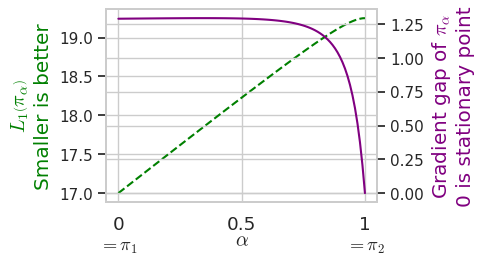

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
sns.set_theme(font_scale=1.2)
fig = plt.figure(figsize=(3.5, 2.5))

with sns.axes_style("whitegrid"):
    color1 = "green"
    ax1 = fig.add_subplot(111)
    plt.plot(alphas, Llamlist, linestyle="--", label=r"$L_1(\pi_\alpha)$", color=color1)
    ax1.tick_params(axis='y', which='major', labelsize=11)
    ax1.xaxis.set_label_coords(0.5, -0.15)
    ax1.set_ylabel(r"$L_1\left(\pi_\alpha \right)$" "\n" "Smaller is better", color=color1)
    ax1.set_xlabel(r"$\alpha$")
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    labels[1] = "0" "\n" r"$=\pi_1$"
    labels[-2] = "1" "\n" r"$=\pi_2$"
    ax1.set_xticklabels(labels)

    color2 = "purple"
    ax2 = ax1.twinx()
    plt.plot(alphas, Lspanlist, color=color2, label=r"$g_\alpha (s, a_1) - g_\alpha (s, a_2)$")
    ax2.set_ylabel(r"Gradient gap of $\pi_\alpha$" "\n" "0 is stationary point", color=color2)
    ax2.tick_params(axis='y', which='major', labelsize=11)

plt.savefig(f"conflict.pdf", bbox_inches="tight")
plt.savefig(f"conflict.png", bbox_inches="tight")